# Knapsack DRL - Demo Experiment

This demo file demonstrates how is the basic experiment for solving the 0-1 Knapsack Problem by comparing three RL approaches (A2C, PPO, DQN) against traditional methods (Dynamic Programming, Greedy).

**Brief explaination to the 0-1 Knapsack Problem**:
- Given n items, each with value v_i and weight w_i
- And a knapsack with capacity W
- Choose items to maximize total value without exceeding capacity
- Each item can be chosen once (0-1)


## setup

In [ ]:
#import everything
import sys
import os

sys.path.append(os.path.abspath('..'))  # Add parent directory to path

import numpy as np
import torch
import matplotlib.pyplot as plt
from environment.knapsackgym import KnapsackEnv
from util.instance_gen import KnapsackInstanceGenerator
from models.KnapsackDRLSolver import KnapsackDRLSolver
from models.KnapsackA2C import KnapsackA2C
from models.KnapsackPPO import KnapsackPPOSolver
from models.KnapsackQLearning import KnapsackDQN
from models.DP_Knapsack import solve_KP_instances_with_DP
from models.Greedy_Knapsack import solve_problem_instances_greedy
from util.metrics import evaluate_knapsack_performance




: 

In [11]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

## Generate problem instances

The KnapsackInstanceGenerator creates different types of problem instances:
- RI (Random Instances): Random values and weights
- FI (Fixed Instances): Fixed capacity with uniform values/weights
- HI (Hard Instances): Strongly correlated values and weights
- SS (Subset Sum): Special case where values = weights

In [12]:
generator = KnapsackInstanceGenerator(seed=42)

# Generate 10 training instances and 5 test instances
n_items = 20
train_instances = generator.generate('RI', M=10, N=n_items, R=100)
test_instances = generator.generate('RI', M=5, N=n_items, R=100)

print("demo train instances:")
print(train_instances)
print("demo test instances:")
print(test_instances)

demo train instances:
[{'values': [44, 44], 'weights': [78, 66], 'capacity': 259}, {'values': [10, 53], 'weights': [70, 21], 'capacity': 293}, {'values': [55, 45, 46, 23, 10, 56, 89, 7, 86, 83, 28, 64, 17, 76, 71], 'weights': [77, 72, 79, 52, 13, 84, 46, 51, 38, 19, 93, 79, 65, 41, 83], 'capacity': 113}, {'values': [90, 68], 'weights': [98, 45], 'capacity': 236}, {'values': [38, 8, 47, 80, 19, 47, 13, 69, 48, 34, 23, 57, 67, 95, 44, 17], 'weights': [20, 37, 47, 50, 5, 55, 16, 75, 69, 93, 75, 37, 97, 42, 33, 91], 'capacity': 252}, {'values': [64, 14, 84, 20, 81, 1, 80, 79, 79, 67, 48, 71, 28], 'weights': [71, 10, 32, 77, 84, 44, 81, 85, 39, 90, 29, 24, 69], 'capacity': 237}, {'values': [57, 8, 77, 58, 64, 57, 56, 10, 56, 80, 31, 61], 'weights': [46, 51, 57, 4, 14, 25, 12, 44, 67, 66, 48, 86], 'capacity': 18}, {'values': [4, 24, 83, 6, 86, 29, 92], 'weights': [44, 99, 22, 28, 41, 100, 86], 'capacity': 95}, {'values': [42, 82, 33, 17, 34, 3, 11, 10, 78], 'weights': [67, 13, 56, 51, 79, 10

## Set up environment

KnapsackEnv is a custom OpenAI Gym environment that simulates the Knapsack problem:

State representation: 
- Vector of size (2*n + 4) containing (value, weight) pairs for each item
- Plus 4 metadata values: [capacity, sum(values), sum(weights), n_items]

Actions:
- Choose which item to place in knapsack (0 to n-1)

Rewards:
- Positive reward when an item fits (based on value/weight ratio)
- Negative reward when an item doesn't fit (penalty based on weight)


In [13]:
env = KnapsackEnv(train_instances[0], N=n_items)

## Create and train different solvers
Comparing three reinforcement learning algorithms:

1. A2C (Advantage Actor-Critic):
   - Hybrid approach with policy and value networks
   - Policy network: Decides which actions to take
   - Value network: Estimates how good each state is
   - Uses "advantage" (how much better an action is than average)

2. PPO (Proximal Policy Optimization):
   - Policy gradient method with stability improvements
   - Uses clipped surrogate objective to prevent too large updates
   - Often more sample-efficient than A2C

3. DQN (Deep Q-Network):
   - Value-based approach that learns Q-values for state-action pairs
   - Uses experience replay to break correlations in training data
   - Uses separate target network for stability

In [9]:
solvers = {}
training_steps = 5000  # Small number for demo
use_aggregation = False 

print("\n=== Training A2C ===")
a2c_policy = KnapsackA2C(N=n_items, gamma=0.99)
a2c_solver = KnapsackDRLSolver(env, a2c_policy, use_state_aggregation=use_aggregation)
a2c_solver.train(train_instances, t_max=training_steps)
solvers['A2C'] = a2c_solver

print("\n=== Training PPO ===")
ppo_policy = KnapsackPPOSolver(N=n_items, gamma=0.99)
ppo_solver = KnapsackDRLSolver(env, ppo_policy, use_state_aggregation=use_aggregation)
ppo_solver.train(train_instances, t_max=training_steps)
solvers['PPO'] = ppo_solver

print("\n=== Training DQN ===")
dqn_policy = KnapsackDQN(N=n_items, gamma=0.99)
dqn_solver = KnapsackDRLSolver(env, dqn_policy, use_state_aggregation=use_aggregation)
dqn_solver.train(train_instances, t_max=training_steps)
solvers['DQN'] = dqn_solver


=== Training A2C ===
Training on 10 KP Instances, with N=20, t_max=5000
Iteration [0/5000], Training KP Instance 0, Reward: 0.0023760023760023763


/Users/bohan/Desktop/McGill/COMP579FINALPROJECT/models/KnapsackA2C.py:233: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  states_tensor = torch.FloatTensor(states)


Iteration [1000/5000], Training KP Instance 0, Reward: 0.0023760023760023763
Iteration [2000/5000], Training KP Instance 0, Reward: 0.0023760023760023763
Iteration [3000/5000], Training KP Instance 0, Reward: 0.0023760023760023763
Iteration [4000/5000], Training KP Instance 0, Reward: 0.0023760023760023763

=== Training PPO ===
Training on 10 KP Instances, with N=20, t_max=5000
[PPO update] AvgReturn: 0.004, PolicyLoss: -0.9044, ValueLoss: 0.2487
Iteration [0/5000], Training KP Instance 0, Reward: 0.0023760023760023763
[PPO update] AvgReturn: 0.009, PolicyLoss: -0.5240, ValueLoss: 0.0426
[PPO update] AvgReturn: -2.563, PolicyLoss: 2.1252, ValueLoss: 6.6579
[PPO update] AvgReturn: 0.007, PolicyLoss: -0.2321, ValueLoss: 0.0964
[PPO update] AvgReturn: -1.189, PolicyLoss: 0.6501, ValueLoss: 0.8278
[PPO update] AvgReturn: -0.837, PolicyLoss: 0.2047, ValueLoss: 0.1708
[PPO update] AvgReturn: -15.196, PolicyLoss: 11.7147, ValueLoss: 252.3491
[PPO update] AvgReturn: -1.831, PolicyLoss: 0.6875,

## RL solvers on test instances
KnapsackDRLSolver.solve() returns a tuple with the solution:
- (selected_items, total_value, total_weight)

The indices are:
- 0: List of selected item indices
- 1: Total value of the solution
- 2: Total weight of the solution

In [14]:
print("\n=== Evaluating Solvers ===")
results = {}

# Debug the structure of the solution
test_solution = a2c_solver.solve(test_instances[0])
print(f"Solution type: {type(test_solution)}")
print(f"Solution content: {test_solution}")

for name, solver in solvers.items():
    print(f"Evaluating {name}...")
    instance_results = []
    
    for i, instance in enumerate(test_instances):
        solution = solver.solve(instance)
        # Extract total value (second element in the tuple)
        total_value = solution[1]  # Using index 1 for total_value
        instance_results.append(total_value)
    
    results[name] = instance_results


=== Evaluating Solvers ===
Solution type: <class 'tuple'>
Solution content: (86.0, 81.0, [0, 3, 5])
Evaluating A2C...
Evaluating PPO...
Evaluating DQN...


## baseline results

Construct basic algo
1. Dynamic Programming (DP_Knapsack.py):
   - Optimal solution but with O(n×W) complexity
   - Uses a table to build up solutions for subproblems
   - Returns optimal value, selected items, and weight
   

2. Greedy Heuristic (Greedy_Knapsack.py):
   - Fast but suboptimal solution
   - Sorts items by value/weight ratio, takes highest first
   - Returns values, selected items, and weights
   


In [17]:
_, optimal_values, _ = solve_KP_instances_with_DP(test_instances)
greedy_values, _, _ = solve_problem_instances_greedy(test_instances)

## Display and compare results


In [16]:
print(f"{'Instance':<10}{'Optimal':<12}{'Greedy':<12}", end="")
for name in solvers.keys():
    print(f"{name:<12}", end="")
print()

print("-" * (10 + 12 + 12 + 12 * len(solvers)))

for i in range(len(test_instances)):
    print(f"{i:<10}{optimal_values[i]:<12.2f}{greedy_values[i]:<12.2f}", end="")
    for name in solvers.keys():
        print(f"{results[name][i]:<12.2f}", end="")
    print()

Instance  Optimal     Greedy      A2C         PPO         DQN         
----------------------------------------------------------------------
0         94.00       86.00       81.00       77.00       79.00       
1         151.00      151.00      45.00       52.00       59.00       
2         156.00      154.00      138.00      142.00      121.00      
3         365.00      365.00      123.00      111.00      110.00      
4         201.00      201.00      179.00      186.00      177.00      


## Calculate performance metrics
Performance metrics calculated by util/metrics.py include:

- N: Number of problem instances
- AveragedVal: Average solution value across instances
- #opt: Number of instances where the algorithm found the optimal solution
- ValOptRatio: Percentage of optimal value achieved (solution_value/optimal_value)
- mean_absolute_error: Average absolute difference from optimal
- mean_percentage_error: Average percentage difference from optimal
- mean_improvement_over_greedy: How much better than greedy (as ratio)

In [18]:
print("\n=== Performance Metrics ===")
for name, values in results.items():
    metrics = evaluate_knapsack_performance(values, optimal_values, greedy_values)
    
    print(f"\n{name} Metrics:")
    print(f"  Number of instances: {metrics['N']}")
    print(f"  Average value: {metrics['AveragedVal']:.2f}")
    print(f"  Found optimal solutions: {metrics['#opt']} out of {len(test_instances)}")
    print(f"  Value ratio to optimal: {metrics['ValOptRatio']:.2f}%")
    print(f"  Mean percentage error: {metrics['mean_percentage_error']:.2f}")
    print(f"  Mean improvement over greedy: {metrics['mean_improvement_over_greedy']:.4f}")



=== Performance Metrics ===

A2C Metrics:
  Number of instances: 5
  Average value: 113.20
  Found optimal solutions: 0 out of 5
  Value ratio to optimal: 58.53%
  Mean percentage error: 0.35
  Mean improvement over greedy: -0.3260

PPO Metrics:
  Number of instances: 5
  Average value: 113.60
  Found optimal solutions: 0 out of 5
  Value ratio to optimal: 58.74%
  Mean percentage error: 0.34
  Mean improvement over greedy: -0.3198

DQN Metrics:
  Number of instances: 5
  Average value: 109.20
  Found optimal solutions: 0 out of 5
  Value ratio to optimal: 56.46%
  Mean percentage error: 0.36
  Mean improvement over greedy: -0.3427


## Visualize results

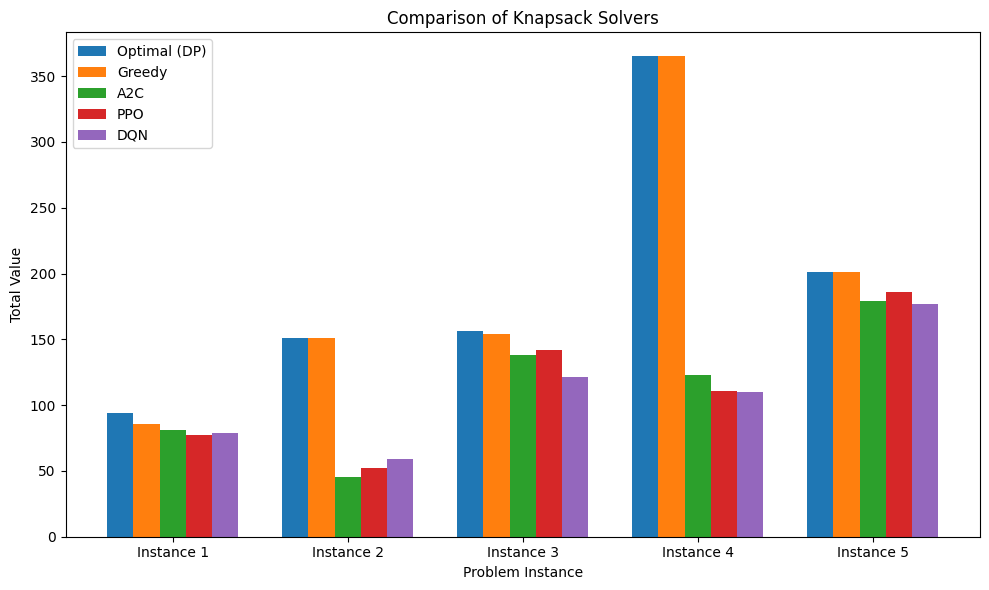

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(test_instances))
width = 0.15
multiplier = 0

# Add bars for each solver
ax.bar(x + width * multiplier, optimal_values, width, label='Optimal (DP)')
multiplier += 1
ax.bar(x + width * multiplier, greedy_values, width, label='Greedy')
multiplier += 1

for name, values in results.items():
    ax.bar(x + width * multiplier, values, width, label=name)
    multiplier += 1

# Add labels and legend
ax.set_xlabel('Problem Instance')
ax.set_ylabel('Total Value')
ax.set_title('Comparison of Knapsack Solvers')
ax.set_xticks(x + width * (multiplier - 1) / 2)
ax.set_xticklabels([f'Instance {i+1}' for i in range(len(test_instances))])
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

`for full experiment result, please refer to full experiment file and the report`